In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

In [251]:
df = pd.read_csv("Fraud.csv")

In [158]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Checking for null values

In [13]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Data Analysis 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [46]:
df['step'].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: count, Length: 743, dtype: int64

In [34]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

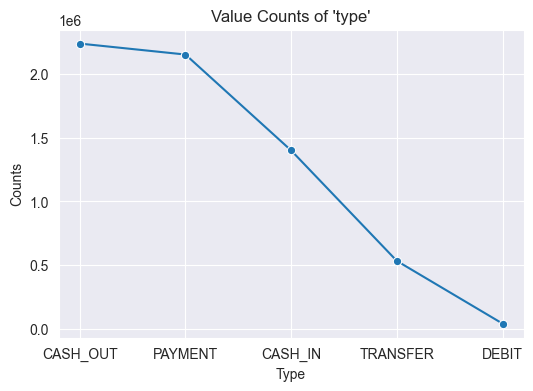

In [33]:
type_counts = df['type'].value_counts()

# Set the grid style to dark
sns.set_style("darkgrid")

# Create the line plot with markers
plt.figure(figsize=(6,4))
sns.lineplot(x=type_counts.index, y=type_counts.values, marker='o')
plt.title("Value Counts of 'type'")
plt.xlabel("Type")
plt.ylabel("Counts")


In [44]:
df['nameOrig'].value_counts() 

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: count, Length: 6353307, dtype: int64

In [45]:
df['nameDest'].value_counts() 

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: count, Length: 2722362, dtype: int64

#### Checking for Outliers

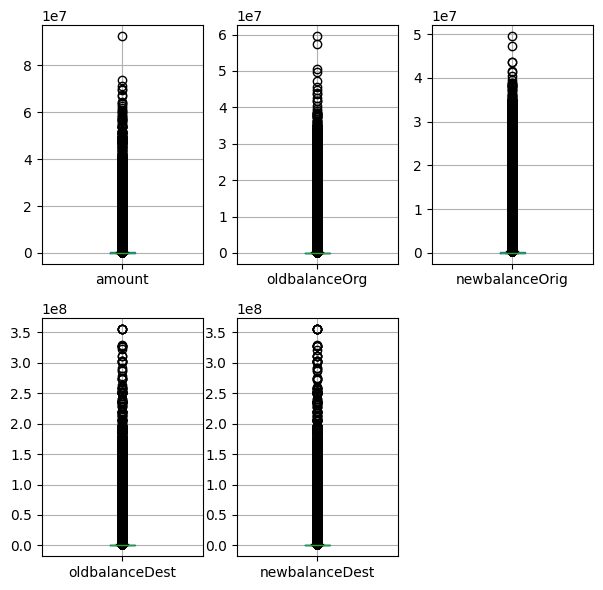

In [242]:
col=df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
fig, axes = plt.subplots(2, 3, figsize=(6,6))

axes = axes.flatten()


for i, (column, ax) in enumerate(zip(col.columns, axes)):
    col.boxplot(column=column, ax=ax)
   


fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()
    

In [161]:
def find_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)][column]
    return outliers

# Columns to check for outliers
columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Find and print outliers for each column
for column in columns:
    outliers = find_outliers(df, column)
    print(f"Outliers in {column}:")
    print(outliers.max())
    print()

Outliers in amount:
92445516.64

Outliers in oldbalanceOrg:
59585040.37

Outliers in newbalanceOrig:
49585040.37

Outliers in oldbalanceDest:
356015889.35

Outliers in newbalanceDest:
356179278.92



In [48]:
df['isFraud'].groupby(df['type']).value_counts().unstack()

isFraud,0,1
type,,
CASH_IN,1399284.0,NaN
CASH_OUT,2233384.0,4116.0
DEBIT,41432.0,NaN
PAYMENT,2151495.0,NaN
TRANSFER,528812.0,4097.0


##### Analyzing data only for the fraud cases

In [260]:
fraudulent_df = df[df['isFraud'] == 1]
isfrd=fraudulent_df.sort_values(by='amount',ascending=False)
isfrd

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3760283,279,CASH_OUT,10000000.0,C1214015158,10000000.00,0.00,C2110157840,0.00,10000000.00,1,0
5987587,409,CASH_OUT,10000000.0,C97242201,10000000.00,0.00,C786701128,8496.86,10008496.86,1,0
1707592,160,CASH_OUT,10000000.0,C525906402,10000000.00,0.00,C43869769,2145275.47,12145275.47,1,0
1707591,160,TRANSFER,10000000.0,C752627210,27670038.08,17670038.08,C1853789265,0.00,0.00,1,0
1707590,160,CASH_OUT,10000000.0,C2068007279,10000000.00,0.00,C836488544,158643.25,10158643.25,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5996410,425,CASH_OUT,0.0,C69493310,0.00,0.00,C719711728,2921531.34,2921531.34,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.00,0.00,C1462759334,76759.90,76759.90,1,0
6362461,730,CASH_OUT,0.0,C729003789,0.00,0.00,C1388096959,1008609.53,1008609.53,1,0
6362463,730,CASH_OUT,0.0,C2088151490,0.00,0.00,C1156763710,0.00,0.00,1,0


In [52]:
df['isFlaggedFraud'].groupby(df['type']).value_counts().unstack()

isFlaggedFraud,0,1
type,,
CASH_IN,1399284.0,NaN
CASH_OUT,2237500.0,NaN
DEBIT,41432.0,NaN
PAYMENT,2151495.0,NaN
TRANSFER,532893.0,16.0


##### From above we can conclude that system captures fraudulent transaction that occurs through transfer. Same is being claimed by the company.

In [252]:
fraudt_df = df[(df['isFraud'] == 1)&(df['isFlaggedFraud']==1) ]
isfr=fraudt_df.sort_values(by='amount',ascending=False)
isfr

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1
6362460,730,TRANSFER,10000000.00,C2140038573,17316255.05,17316255.05,C1395467927,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6362462,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.0,0.0,1,1
6362584,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.0,0.0,1,1
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6296014,671,TRANSFER,3441041.46,C917414431,3441041.46,3441041.46,C1082139865,0.0,0.0,1,1


In [258]:
isfr['nameOrig'].mode()

0     C1035541766
1     C1100582606
2     C1684585475
3     C1869569059
4     C1892216157
5       C19004745
6      C193696150
7     C2140038573
8      C452586515
9      C689608084
10     C724693370
11     C728984460
12     C786455622
13     C908544136
14     C917414431
15     C992223106
Name: nameOrig, dtype: object

In [253]:
isfr['nameDest'].mode()

0     C1082139865
1     C1100697970
2     C1109166882
3     C1147517658
4     C1308068787
5     C1366804249
6     C1392803603
7     C1395467927
8     C1770418982
9     C1806199534
10    C1861208726
11    C1909486199
12     C484597480
13     C639921569
14     C661958277
15     C891140444
Name: nameDest, dtype: object

## Feature Engineering

##### Feature selection (Analyzing features using pearson correlation and feature importance)

In [67]:
numerical_features = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

# Compute correlation matrix
correlation_matrix = numerical_features.corr()

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(len(numerical_features.columns))]

# Display VIF
print("\nVariance Inflation Factors (VIF):")
print(vif_data)

Correlation Matrix:
                  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
amount          1.000000      -0.002762       -0.007861        0.294137   
oldbalanceOrg  -0.002762       1.000000        0.998803        0.066243   
newbalanceOrig -0.007861       0.998803        1.000000        0.067812   
oldbalanceDest  0.294137       0.066243        0.067812        1.000000   
newbalanceDest  0.459304       0.042029        0.041837        0.976569   

                newbalanceDest  
amount                0.459304  
oldbalanceOrg         0.042029  
newbalanceOrig        0.041837  
oldbalanceDest        0.976569  
newbalanceDest        1.000000  

Variance Inflation Factors (VIF):
          Feature         VIF
0          amount    3.861988
1   oldbalanceOrg  464.011728
2  newbalanceOrig  465.356124
3  oldbalanceDest   70.452251
4  newbalanceDest   82.167173


In [ ]:
### Positive Correlations
### Positive correlation between amount and oldbalance dest suggest that larger transaction amounts are associated with higher
### intial balance in the desitination account


#### positive correlation (0.976) between 'oldbalanceDest' and 'newbalanceDest', 
#### indicating that the initial balance in the destination account strongly 
#### predicts the new balance after the transaction

####positive correlation (0.459) between 'amount' and 'newbalanceDest', 
#### indicating that larger transaction amounts 
#### are associated with higher new balances in the destination account.

#### Correlation between 'amount' and 'oldbalanceOrg' as well as 'newbalanceOrig' 
#### is very weak (close to 0), suggesting little to no linear 
#### relationship between transaction amount and the originator's initial or new balance.



### correlation between 'amount' and 'oldbalanceOrg' as well as 
### 'newbalanceOrig' is very weak (close to 0), 
### suggesting little to no linear relationship 

### correlation between 'oldbalanceOrg' and 'oldbalanceDest', as well as 'newbalanceOrig' 
### and 'newbalanceDest', 
### is also weak (0.066 and 0.042 respectively), indicating little linear relationship

#### Encoding categorical values

In [162]:
categorical_features = ['type','nameOrig','nameDest']
# Initialize a dictionary to hold label encoders
label_encoders = {}

# Iterate over categorical features and encode them
for feature in categorical_features:
    # Initialize LabelEncoder for the feature
    le = LabelEncoder()
    # Fit and transform the feature
    df[feature] = le.fit_transform(df[feature])
    # Store the label encoder in the dictionary
    label_encoders[feature] = le
    # Print the label encoding mapping
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Label encoding mapping for {feature}:", label_mapping)

Label encoding mapping for type: {'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}
Label encoding mapping for nameOrig: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Label encoding mapping for nameDest: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [163]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.00,160296.36,1662094,0.00,0.00,0,0
1,1,3,1864.28,2188998,21249.00,19384.72,1733924,0.00,0.00,0,0
2,1,4,181.00,1002156,181.00,0.00,439685,0.00,0.00,1,0
3,1,1,181.00,5828262,181.00,0.00,391696,21182.00,0.00,1,0
4,1,3,11668.14,3445981,41554.00,29885.86,828919,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,5651847,339682.13,0.00,505863,0.00,339682.13,1,0
6362616,743,4,6311409.28,1737278,6311409.28,0.00,260949,0.00,0.00,1,0
6362617,743,1,6311409.28,533958,6311409.28,0.00,108224,68488.84,6379898.11,1,0
6362618,743,4,850002.52,2252932,850002.52,0.00,319713,0.00,0.00,1,0


In [171]:
X= df.drop(columns=['isFraud'])
y=df['isFraud']

In [172]:
X_train , X_test ,y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((4453834, 10), (1908786, 10))

##1. Feature Selection (Chi2 and Pearson Correlation)

#### Ranking features on Importance

In [165]:
ordered_rank_features= SelectKBest(score_func=chi2,k=10)
ordered_features= ordered_rank_features.fit(X,y)
dfscores=pd.DataFrame (ordered_features.scores_,columns=['Scores'])     

In [166]:
dfscores=pd.DataFrame (ordered_features.scores_,columns=['Scores'])
dfcolumns=pd.DataFrame(X.columns)
features_rank=pd.concat([dfcolumns,dfscores],axis=1)
features_rank.sort_values(by='Scores',ascending=False)

,0,Scores
2,amount,7.586237e+10
4,oldbalanceOrg,6.563092e+09
5,newbalanceOrig,4.223772e+09
6,nameDest,2.314492e+09
7,oldbalanceDest,2.313389e+09
8,newbalanceDest,2.009466e+07
3,nameOrig,1.449133e+06
0,step,5.280591e+05
9,isFlaggedFraud,1.237922e+04
1,type,2.936631e+03


#### Visualzing feature importance using extra tree classifier

In [167]:
model=ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [168]:
print(model.feature_importances_)

[0.13069745 0.03221578 0.17859987 0.04241638 0.28171482 0.06205563
 0.04450379 0.05566281 0.1706382  0.00149527]


<Axes: >

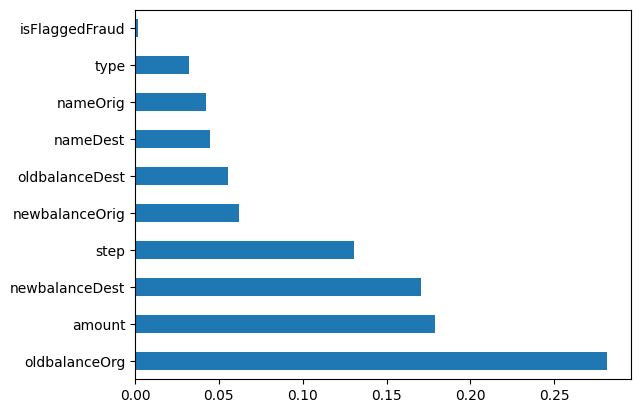

In [169]:
ranked_features_index = pd.Series(model.feature_importances_, index=X.columns)
ranked_features = ranked_features_index.nlargest(10)
ranked_features.plot(kind='barh')

#### Correlation Matrix 

<function matplotlib.pyplot.show(close=None, block=None)>

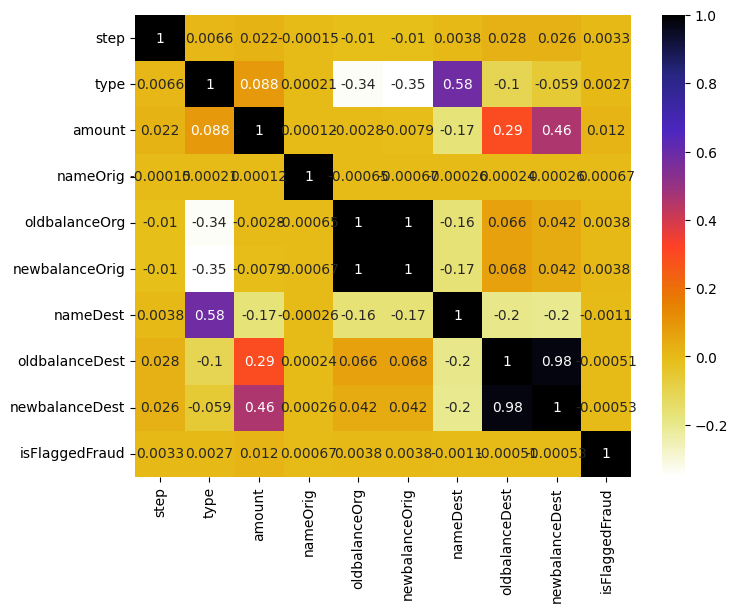

In [174]:
plt.figure(figsize=(8,6))
numeric_columns=['step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest','isFlaggedFraud']
numeric_columns = X.select_dtypes(include=['number'])


cor = numeric_columns.corr()

sns.heatmap(cor,annot=True, cmap=plt.cm.CMRmap_r)
plt.show

##### After analyzing feature importance through chi2 we found out of 'oldbalanceDest' and 'newbalanceDest'& oldbalanceOrg' as well as 'newbalanceOrig'
##### showing  high collinearity.oldbalanceDest and newbalanceOrig are less important.

##### We will try reducing the dimensionality using PCA . 

##### Will evaluate performance of both the case on randomforest using classification metrics to see the variations

In [ ]:
###Feature Selection and Extraction

##Feature Selection:
##•	Feature Importance: Analyzed using Chi-square test and visualized with Extra Trees Classifier.
#3•	Pearson Correlation: Visualized with a heatmap to identify highly correlated features.
##•	Dropped less important features like newbalanceOrig and oldbalanceDest.

##Feature Extraction:
##•	Applied Principal Component Analysis (PCA) to combine oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest into two principal components.


##### Randomforest Model (dropping columns )

In [207]:
sample_size = 10000
target_variable = 'isFraud'
df_sampled = df.sample(n=sample_size, random_state=42)  # Random sampling without replacement

# Separate features and target variable
X = df_sampled.drop(target_variable, axis=1)
y = df_sampled[target_variable]

# Split the sampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.drop(columns=['newbalanceOrig','oldbalanceDest'])
X_test=X_test.drop(columns=['newbalanceOrig','oldbalanceDest'])

In [208]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_val=X_val.drop(columns=['newbalanceOrig','oldbalanceDest'])

In [180]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.9973333333333333
Precision: 0.9973404491883479
Recall: 0.9973333333333333
F1 Score: 0.9964462257849032

Testing Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0



#### Feature Extraction using PCA and evaluating the model

In [191]:
features_group1 = ['oldbalanceOrg', 'newbalanceOrig']
features_group2 = ['oldbalanceDest', 'newbalanceDest']

# Standardize the features in each group
scaler1 = StandardScaler()
df_scaled_group1 = scaler1.fit_transform(df[features_group1])

scaler2 = StandardScaler()
df_scaled_group2 = scaler2.fit_transform(df[features_group2])

# Apply PCA to each group
pca1 = PCA(n_components=1)  # Reduce to 1 principal component
df_pca_group1 = pca1.fit_transform(df_scaled_group1)

pca2 = PCA(n_components=1)  # Reduce to 1 principal component
df_pca_group2 = pca2.fit_transform(df_scaled_group2)

# Create DataFrames with the principal components
df_pca_group1 = pd.DataFrame(df_pca_group1, columns=['PCA_Component_Group1'])
df_pca_group2 = pd.DataFrame(df_pca_group2, columns=['PCA_Component_Group2'])

# Drop the original features from the DataFrame
df_dropped = df.drop(columns=features_group1 + features_group2)

# Concatenate the principal components with the rest of the DataFrame
df_final = pd.concat([df_dropped, df_pca_group1, df_pca_group2], axis=1)

print(df_final.head())

   step  type    amount  nameOrig  nameDest  isFraud  isFlaggedFraud  \
0     1     3   9839.64    757869   1662094        0               0   
1     1     3   1864.28   2188998   1733924        0               0   
2     1     4    181.00   1002156    439685        1               0   
3     1     1    181.00   5828262    391696        1               0   
4     1     3  11668.14   3445981    828919        0               0   

   PCA_Component_Group1  PCA_Component_Group2  
0             -0.330524             -0.464728  
1             -0.401051             -0.464728  
2             -0.410897             -0.464728  
3             -0.410897             -0.460322  
4             -0.393540             -0.464728  


#### Model using PCA

In [204]:
sample_size = 10000
target_variable = 'isFraud'
df_sampled = df_final.sample(n=sample_size, random_state=42)  # Random sampling without replacement

# Separate features and target variable
X = df_sampled.drop(target_variable, axis=1)
y = df_sampled[target_variable]

# Split the sampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [206]:
### EVALUATING PCA MODEL

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.998
Precision: 0.998004005340454
Recall: 0.998
F1 Score: 0.9975724309102191

Testing Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0



In [ ]:
#####. Model Evaluation
###•	Compared Random Forest models with and without PCA.
#### •	Chose the model without PCA for better interpretability.


### Model Selection

###### ADABOOST ||| XGBOOST ||| GRADIENTBOOST

In [229]:
sample_size = 10000
target_variable = 'isFraud'
df_sampled = df.sample(n=sample_size, random_state=42)  # Random sampling without replacement

# Separate features and target variable
X = df_sampled.drop(target_variable, axis=1)
y = df_sampled[target_variable]

# Split the sampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.drop(columns=['newbalanceOrig','oldbalanceDest'])
X_test=X_test.drop(columns=['newbalanceOrig','oldbalanceDest'])

In [230]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_val=X_val.drop(columns=['newbalanceOrig','oldbalanceDest'])

In [217]:
ad_model=AdaBoostClassifier()

ad_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = ad_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = ad_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

C:\Users\SK SHARMA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation Set Metrics:
Accuracy: 0.998
Precision: 0.9978342245989305
Recall: 0.998
F1 Score: 0.9978892232252312

Testing Set Metrics:
Accuracy: 0.9985
Precision: 0.9982505005005005
Recall: 0.9985
F1 Score: 0.9983501877346684



In [219]:
xg_model= XGBClassifier() 


xg_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = xg_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = xg_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.9986666666666667
Precision: 0.9986684480071253
Recall: 0.9986666666666667
F1 Score: 0.9985004456327986

Testing Set Metrics:
Accuracy: 0.999
Precision: 0.99900100050025
Recall: 0.999
F1 Score: 0.9987502502502502



In [220]:
gdb_model= GradientBoostingClassifier()
gdb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = gdb_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = gdb_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.9986666666666667
Precision: 0.9986684480071253
Recall: 0.9986666666666667
F1 Score: 0.9985004456327986

Testing Set Metrics:
Accuracy: 0.9985
Precision: 0.9982505005005005
Recall: 0.9985
F1 Score: 0.9983501877346684



#### Xgboost Model for FRAUD DETECTION

In [239]:
print("Fraud Detection ")
a = float(input("step (1-744)   : "))
b = float(input("Type of Transaction (Cash_in = 0, Cash_out = 1, Debit=2 ,Payment=3, Transfer=4) : "))
c = float(input("Amount(Amount of Transaction)	: "))
d = float(input("NameOrig(Id of Customer intiating Transaction)  : "))
e = float(input("Old_balalnce(Balance Before Transaction)	: "))
f = float(input("Name_Dest(Recepient Account): "))
g = float(input("New_Balance_Dest(Recepient Account Balance)	: "))
h = float(input("Flagged_Fraud(YES:1 ,NO:0)	: "))


features = np.array([[a, b, c, d, e,f,g,h]])
print("FRAUD TRANSACTION::: ", xg_model.predict(features))

Fraud Detection 


step (1-744)   :  744
Type of Transaction (Cash_in = 0, Cash_out = 1, Debit=2 ,Payment=3, Transfer=4) :  4
Amount(Amount of Transaction)	:  6311409.28
NameOrig(Id of Customer intiating Transaction)  :  1737278
Old_balalnce(Balance Before Transaction)	:  6311409.28
Name_Dest(Recepient Account):  2600949
New_Balance_Dest(Recepient Account Balance)	:  0.00
Flagged_Fraud(YES:1 ,NO:0)	:  1


FRAUD TRANSACTION:::  [1]


In [ ]:
#######Evaluated different models: Random Forest, AdaBoost, XGBoost, and Gradient Boosting.
#######Trained and evaluated each model on testing and validation data.

##### Result:
##•	XGBoost and Gradient Boosting performed similarly well.
##•	Random Forest showed high metrics but also signs of overfitting.
##•	AdaBoost performed well but slightly less effectively.

##Conclusion:
##•	XGBoost is the best choice because it:
##1.	Has the highest accuracy, precision, recall, and F1 score on both validation and testing sets.
##2.	Offers robust generalization and efficiency, crucial for real-world fraud detection.


In [1]:
                                            Fraudulent Transaction Predicting Model
1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
Flow of the Model:
1.	Loading the Dataset
2.	Data Cleaning
3.	Data Analysis (Focusing on Outliers and Correlation)
4.	Feature Engineering
5.	Feature Selection
6.	Feature Extraction
7.	Evaluating Different Models
8.	Training and Evaluating the Final Model
1. Data Cleaning
•	The dataset had no missing or null values.
2. Data Analysis

Outliers:
•	Visualized using boxplots.
•	Not removed because XGBoost can handle them well.
•	Outliers in fraud cases can be significant and should be retained.

Multicollinearity:
•	Checked using correlation matrix and variance inflation factor (VIF).
3. Feature Encoding
•	Used label encoding for categorical features like type, nameOrig, and nameDest.

3. How did you select variables to be included in the model?
4. Feature Selection and Extraction

Feature Selection:
•	Feature Importance: Analyzed using Chi-square test and visualized with Extra Trees Classifier.
•	Pearson Correlation: Visualized with a heatmap to identify highly correlated features.
•	Dropped less important features like newbalanceOrig and oldbalanceDest.

Feature Extraction:
•	Applied Principal Component Analysis (PCA) to combine oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest into two principal components.

5. Model Evaluation
•	Compared Random Forest models with and without PCA.
•	Chose the model without PCA for better interpretability.

6. Model Selection
•	Evaluated different models: Random Forest, AdaBoost, XGBoost, and Gradient Boosting.
•	Trained and evaluated each model on testing and validation data.

Result:
•	XGBoost and Gradient Boosting performed similarly well.
•	Random Forest showed high metrics but also signs of overfitting.
•	AdaBoost performed well but slightly less effectively.

Conclusion:
•	XGBoost is the best choice because it:
1.	Has the highest accuracy, precision, recall, and F1 score on both validation and testing sets.
2.	Offers robust generalization and efficiency, crucial for real-world fraud detection.
Summary
XGBoost is selected for its balanced performance and efficiency, making it suitable for detecting fraudulent transactions in banking.

                         5. What are the key factors that predict fraudulent customer?  
                           6. Do these factors make sense? If yes, How? If not, How not?  
key factors that predict fraudulent customer behavior involves analyzing the features of the dataset and understanding the characteristics of transactions that are likely to be fraudulent.

Transaction Type (type):
Certain types of transactions, such as "TRANSFER" and "CASH_OUT", are more likely to be associated with fraudulent activities. Fraudsters often transfer money to another account or cash out the funds quickly.

Transaction Amount (amount):
Unusually large transaction amounts can be a strong indicator of fraud, especially if they deviate significantly from the customer’s typical transaction pattern.

Customer Behavior:
Frequency of Transactions: A sudden increase in the number of transactions within a short period.
Transaction Timing: Transactions made at unusual times (e.g., late night or early morning) may indicate fraudulent activity.

Account Balance Changes:
Old Balance (oldbalanceOrg) and New Balance (newbalanceOrig): Large discrepancies between the initial and new balances could signal suspicious activities.
Recipient’s Balance (oldbalanceDest, newbalanceDest): Similar balance changes in the recipient’s account can also be indicative.

Balance Differences:
Features like balanceOrigDiff (difference between old and new balance of the origin account) and balanceDestDiff (difference between old and new balance of the destination account) can highlight significant changes in account balances that may be linked to fraud.

                            7. What kind of prevention should be adopted while company update its infrastructure? 

Preventive Measures from a Data Scientist's Perspective

1. Data Integrity and Quality:

•	Data Validation: ensure that incoming data is accurate, complete, and free from anomalies.
•	Data Cleaning: Regularly clean the dataset to remove inconsistencies, duplicates, and irrelevant information.
•	Monitoring Data Pipelines: Continuously monitor data pipelines for any disruptions or changes that could affect data quality.
2. Model Performance and Robustness:
•	Regular Retraining: Schedule regular retraining of your model with the latest data to ensure it adapts to new fraud patterns.
•	Cross-Validation: Use cross-validation techniques to validate model performance and prevent overfitting.
•	Hyperparameter Tuning: Continuously tune hyperparameters to maintain optimal model performance.

3.. Anomaly Detection:
•	Baseline Monitoring: Establish baselines for normal behavior and continuously monitor for deviations that could indicate fraud.
•	Real-Time Detection: Implement real-time anomaly detection systems to quickly identify and respond to suspicious activities.
.
4. Model Evaluation and Metrics:
•	Continuous Evaluation: Regularly evaluate the model using relevant metrics like accuracy, precision, recall, and F1-score.
•	Benchmarking: Compare model performance against benchmarks and historical data to identify any degradation in performance.
•	A/B Testing: Conduct A/B testing to evaluate the impact of model updates on fraud detection rates and overall system performance.

                           8. Assuming these actions have been implemented, how would you determine if they work

                                                                                         
Evaluating the Effectiveness of Implemented Actions
To determine if the preventive measures are working, you can implement the following evaluation strategies:

1. Performance Monitoring:
•	Key Metrics: Continuously monitor key metrics such as accuracy, precision, recall, F1-score.
•	Drift Detection: Implement drift detection mechanisms to identify changes in data distribution that could affect model performance.
2. Incident Analysis:
•	Fraud Detection Rates: Track the number of detected fraud cases and compare them with historical data to assess improvements.
•	False Positives/Negatives: Monitor the rates of false positives and false negatives to ensure the model is accurately detecting fraud without unnecessary alerts.

3. User Feedback:
•	Stakeholder Feedback: Collect feedback from stakeholders, including fraud analysts and end-users, to identify areas for improvement.
•	Customer Feedback: Analyze customer feedback related to fraud detection measures to gauge their effectiveness and impact.








SyntaxError: invalid character '•' (U+2022) (1741031121.py, line 14)